In [1]:
from __future__ import print_function, division

In [9]:
import os
import sys
import datetime
import time

import numpy as np
import pandas as pd


import scipy.sparse as sparse

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = '/Users/appry001/Data/ml-20m/pro/'

In [5]:
unique_uid = list()
with open(os.path.join(DATA_DIR, 'unique_uid.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_DIR, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [6]:
n_items = len(unique_sid)
n_users = len(unique_uid)
print(n_users, n_items)

111148 11711


In [10]:
def load_data(csv_file, shape=(n_users, n_items)):
    tp = pd.read_csv(csv_file)
    print(tp.head())
    timestamps, rows, cols = np.array(tp['timestamp']), np.array(tp['uid']), np.array(tp['sid'])
    #seq = np.concatenate((rows[:, None], cols[:, None], np.ones((rows.size, 1), dtype='int'), timestamps[:, None]), axis=1)
    data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int16, shape=shape)
    return data #, seq

In [11]:
train_data = load_data(os.path.join(DATA_DIR, 'train.csv'))

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


   timestamp     uid   sid
0  789652004   22802  1151
1  789652009  105277    46
2  822873600   87053    56
3  822873600   68348    69
4  822873600   80133     0


In [12]:
vad_data = load_data(os.path.join(DATA_DIR, 'validation.csv'))

   timestamp     uid  sid
0  822873600   80133   20
1  822873600   80133   17
2  822873600  107905   10
3  822873600  107905   20
4  823185198   99550   49


In [13]:
test_data = load_data(os.path.join(DATA_DIR, 'test.csv'))

    timestamp    uid    sid
0  1255949513  24501   1167
1  1255949516  66083  10339
2  1255949525  66083   5097
3  1255949529  66083  10343
4  1255949531  24501   1186


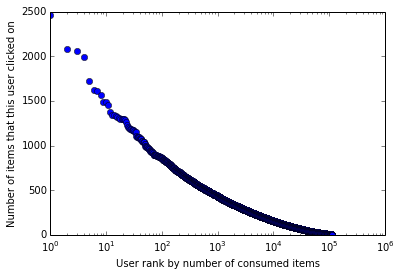

In [14]:
user_activity = np.asarray(train_data.sum(axis=1)).ravel()
plt.semilogx(1 + np.arange(n_users), -np.sort(-user_activity), 'o')
plt.ylabel('Number of items that this user clicked on')
plt.xlabel('User rank by number of consumed items')
pass

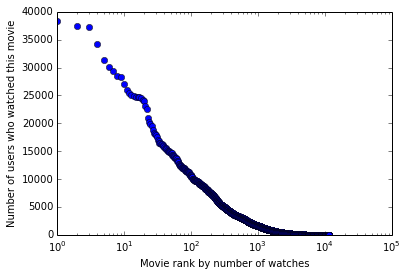

In [15]:
watches_per_movie = np.asarray(train_data.astype('int64').sum(axis=0)).ravel()
plt.semilogx(1 + np.arange(n_items), -np.sort(-watches_per_movie), 'o')
plt.ylabel('Number of users who watched this movie')
plt.xlabel('Movie rank by number of watches')
pass

In [51]:
def linear_surplus_confidence_matrix(B, alpha):
    # To construct the surplus confidence matrix, we need to operate only on
    # the nonzero elements.
    # This is not possible: S = alpha * B
    S = B.copy()
    S.data = alpha * S.data
    return S

In [59]:
#recompute_factors=batched_inv_joblib.recompute_factors_batched
def get_row(S, i):
    lo, hi = S.indptr[i], S.indptr[i + 1]
    return S.data[lo:hi], S.indices[lo:hi]


def solve_sequential(As, Bs):
    X_stack = np.empty_like(As, dtype=As.dtype)

    for k in xrange(As.shape[0]):
        X_stack[k] = np.linalg.solve(Bs[k], As[k])

    return X_stack

def recompute_factors_full(Y, S, lambda_reg):
    
    m = S.shape[0]  # m = number of users
    f = Y.shape[1]  # f = number of factors

    YTY = np.dot(Y.T, Y)  # precompute this
    YTYpR = YTY + lambda_reg * np.eye(f)

    
    A_stack = np.empty((m, f), dtype='float32')
    B_stack = np.empty((m, f, f), dtype='float32')

    for u in xrange(m):
        s_u, i_u = get_row(S, u)
        # i_u indexes the nz item elements for user u

        Y_u = Y[i_u]  # exploit sparsity

        A = (s_u + 1).dot(Y_u)

        YTSY = np.dot(Y_u.T, (Y_u * s_u[:, None]))
        B = YTSY + YTYpR

        A_stack[u] = A
        B_stack[u] = B
        
        if u == 0:
            print('i_u ', i_u)
            print('s_u ', s_u.shape)
            print('Y_u ', Y_u.shape)
            print('A ', A.shape)
            print('YTSY ', YTSY.shape)
            print('B ', B.shape)
            

    X_stack = solve_sequential(A_stack, B_stack)
    
    return X_stack





In [60]:
# summarize WMF_ML20M
num_factors = 100
num_iters = 1
#lam_theta = lam_beta = 1e-5
lambda_U_reg = 1e-5
lambda_V_reg = 1e-5
alpha = 10
init_std=0.01

S = linear_surplus_confidence_matrix(train_data, alpha=alpha)

num_users, num_items = S.shape

ST = S.T.tocsr()

random_state=98765
if type(random_state) is int:
    np.random.seed(random_state)
elif random_state is not None:
    np.random.setstate(random_state)
V = np.random.randn(num_items, num_factors).astype('float32') * init_std

for i in xrange(num_iters):
    print("Iteration %d:" % i)
    
    print('\tUpdating user factors...')
    start_time = time.time()
    U = recompute_factors_full(V, S, lambda_U_reg)
    print('\tUser update time=%.2f' % (time.time() - start_time))
    
    print('\tUpdating item factors...')
    start_time = time.time()
    #V = recompute_factors_full(U, ST, lambda_V_reg)
    print('\tItem update time=%.2f' % (time.time() - start_time))




Iteration 0:
	Updating user factors...
i_u  [ 149  220  250  257  290  293  537 1015 1055 1073 1173 1186 1187 1191 1210
 1219 1229 1248 1290 1302 1326 1341 1354 1880 1934 2013 2031 2051 2053 2056
 2086 2087 2106 2195 2198 2448 2534 2667 2777 2849 2864 2873 2984 3056 3373
 3382 3392 3776 3880 3895 3911 4187 4348 4452 4633 4787 4869 4915 5405 5649
 5667 5795 5933 6166 6357 6565 6583 6847 6952 7182 7214 7230 7347 7650 7733
 7823 8134]
s_u  (77,)
Y_u  (77, 100)
A  (100,)
YTSY  (100, 100)
B  (100, 100)
	User update time=45.93
	Updating item factors...
	Item update time=0.00


In [54]:
U[0]

array([ 0.47483447, -0.45262411,  0.12922375, -0.37676117, -1.82800055,
        0.5996694 , -0.82891166,  0.38306516,  0.10334159, -0.58245152,
        0.06795751, -1.05457795,  1.27783525, -0.58131236, -0.29370022,
        0.32481018,  0.37592852,  0.29745358,  1.30121052, -0.00357365,
        0.66819078, -0.98151368,  0.3816582 , -0.57974958, -1.92892361,
        0.53237849, -0.07437876, -0.22442238,  0.53737158, -1.11361492,
       -0.52870733, -0.10714696,  0.07809896,  0.22033608, -0.36906809,
       -0.37337652,  0.70809895, -0.84612507,  1.29883635,  0.08175272,
       -0.55716425, -0.32196003,  0.11929715, -0.47686729, -0.11620339,
       -1.2678771 ,  0.03485085,  0.29723802, -0.76723731, -0.31596872,
        1.06023335,  0.97439206,  0.77322119, -0.72154772, -0.17960925,
       -0.61731648, -0.33738431,  0.95407182, -0.84338319,  0.72571206,
        0.82911766, -0.14987759,  0.14903134,  0.7739957 ,  0.35197195,
       -1.52633965, -0.02371887,  0.74461204,  0.72278631, -0.78

In [47]:
U[0]

array([ 0.47483447, -0.45262411,  0.12922375, -0.37676117, -1.82800055,
        0.5996694 , -0.82891166,  0.38306516,  0.10334159, -0.58245152,
        0.06795751, -1.05457795,  1.27783525, -0.58131236, -0.29370022,
        0.32481018,  0.37592852,  0.29745358,  1.30121052, -0.00357365,
        0.66819078, -0.98151368,  0.3816582 , -0.57974958, -1.92892361,
        0.53237849, -0.07437876, -0.22442238,  0.53737158, -1.11361492,
       -0.52870733, -0.10714696,  0.07809896,  0.22033608, -0.36906809,
       -0.37337652,  0.70809895, -0.84612507,  1.29883635,  0.08175272,
       -0.55716425, -0.32196003,  0.11929715, -0.47686729, -0.11620339,
       -1.2678771 ,  0.03485085,  0.29723802, -0.76723731, -0.31596872,
        1.06023335,  0.97439206,  0.77322119, -0.72154772, -0.17960925,
       -0.61731648, -0.33738431,  0.95407182, -0.84338319,  0.72571206,
        0.82911766, -0.14987759,  0.14903134,  0.7739957 ,  0.35197195,
       -1.52633965, -0.02371887,  0.74461204,  0.72278631, -0.78